In [1]:
## Importing necessary packages
from sklearn import datasets
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer

## Task 3

To classify the iris dataset using a QSVM based on a quantum kernel proposed using a parametric circuit

### Iris Dataset

**Features**: Each data-point contains 4 features --> Sepal Length, Sepal Width, Petal Length and Petal Width.  
**Labels**: Entire data can be classified into 3 labels --> Setosa, Versicolour, and Virginica labeled as y = 0,1,2 respectively 

### Pre-processing
We first divide the data-set into:  
1. **Training Data** (0.6) : For training the inital parametric circuit, using which we propose the kernel 
2. **Validation Data** (0.20) : For testing accuracy of parametric circuit 
3. **Test Data** (0.20) : For testing accuracy of QSVM after constructing kernel based on above data


In [2]:
# importing iris dataset from sklearn
iris = datasets.load_iris()
"""The dataset consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) labeled as y = 0,1,2
The associated features are: Sepal Length, Sepal Width, Petal Length and Petal Width.
"""

X = iris.data   ## Features (4 dimensional)
y = iris.target ## Labels

## Dividing data into train, validation(for finding good kernels), test data (evaluating perfomance of QSVM)
train_ratio = 0.6
validation_ratio = 0.20
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=62) 


Next the data is rescaled as $x\rightarrow \frac{x -\bar{X}}{\sigma_x}$ for each of the features. We further multiply it by $\pi/3$. Rescaling the range of data this way, emperically gave good results

In [3]:
## Preprocessing and scaling data
X_train, X_val, X_test = pre.scale(X_train,axis = 0 ),pre.scale(X_val,axis = 0 ), pre.scale(X_test,axis = 0 )
X_train, X_val, X_test = np.pi * X_train/3, np.pi * X_val/3, np.pi * X_test/3

## Choosing kernel from paramteric circuit

In order to choose an appropriate kernel, a parametric circuit was trained on X_train data and validated over X_val data to obtain maximum accuracy. The parametric circuit used is taken from [this paper](https://arxiv.org/pdf/2007.14044) which reported a high classification accuracy. I uploaded the feature data twice on the circuit and use a total of 8 parameters for classification.


Here is an image showing the circuit we used.  
$\omega_i$ correspond to the encoded features and $\theta_i$ denote the learning parameters. The encoded features are uploaded twice for better performance.    
<img src="vqc_circuit.png"  width="60%">

The shown gates are a compact notation defined as follows:  
<img src="notation.png"  width="30%">  
where the $s_x$ denotes an $\sqrt{X}$ gate. Together with $Z(\theta)$ and $CZ$ it forms an universal gate set.

###### Figures taken from https://arxiv.org/pdf/2007.14044





### Mapping circuit output to data-labels
I consider the following mapping from states to data-labels:
$$
00 \rightarrow 0\\
01 \rightarrow 1\\
10 \rightarrow 2\\
$$
while the state 11 is not mapped to any label

In [4]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister

def vqc_circuit(x,theta,features = 4,qubits = 2):
    """
    Creates the VQC circuit containing features x, and learning parameters theta
    
    Input:
        x: (4,) array containing features for a data point
        theta: (8,) array containing learning parameters
        features = No. of features in x
        qubits: No. of qubits used in circuit
        
    Return:
        QuantumCircuit executing the classification 
    """
    
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)

    ## Implements the circuit shown above
    theta_ind=0
    for _ in range(int(len(theta)/4)):
        
        ## Encodes the features
        feautre_ind=0
        for _ in range(int(features/2)):
            qc.sx(range(qubits))
            for j in range(qubits):
                qc.rz(x[feautre_ind],j)
                feautre_ind+=1
            qc.sx(range(qubits))   

            qc.cz(0,1)
            
            ## Applies the learning parameters
            qc.sx(range(qubits))
            for j in range(qubits):
                qc.rz(theta[theta_ind],j)
                theta_ind+=1
            qc.sx(range(qubits))  
            qc.cz(0,1) 

        
        qc.barrier()
        
    qc.measure(qr,cr)
    
    return qc


## Loss function for training

For each evaluation, the parameters $\theta$ are updated to minimize the following loss function,
$$
L({\theta}) = \frac{1}{N}\sum_j^N \Big(\sum_{i = 0}^4 p_i C_i\Big),\quad \text{where } C_i =   \left\{
\begin{array}{ll}
      0 & y_{pred} = y_{exact} \\
      1 & y_{pred} \neq y_{exact} \\
\end{array} 
\right.  
$$

The functions below are used measuring this loss function

In [5]:
def loss_train(x,y,theta, shots=1024):
    """
    Measures loss function for each training data point
    Input: 
        x: Features of data point
        y: Label of datapoint (0,1,2)
        theta: Learning parameters
        shots: No. of shots of quantum circuit
        
    Returns:
        Loss function value for each datapoint
    """
    
    qc = vqc_circuit(x,theta)
    
    ## Choosing backend for training
    backend = Aer.get_backend('aer_simulator')
    counts = backend.run(qc, seed_simulator=10,shots=shots).result().get_counts()
    
    ## Measuring expectation on each training datapoint
    exp = 0
    for state in counts:
        y_eval = int(state,2)
        if y_eval != y:
            exp += counts[state]/shots
    return exp

                
def average_loss_train(theta,shots = 1024):
    """
    Average loss function over entire training batch
    Input:
        theta: Learning parameters
        shots: No. of shots of quantum circuit
        
    Return:
        Average loss function over entire training data
        
    """
    
    error = 0
    samples = len(X_train)
    
    ## Averaging over all training datapoints
    for ind in range(len(X_train)):
        error += loss_train(X_train[ind],y_train[ind],theta,shots)

    return error/samples


## Validation

To measure accuracy of prediction on validation set, we apply the trained parametrized circuit on X_val data and take the most probable output as our prediction. Success of model is defined as number of correct predictions over the X_val dataset.  
The functions below are used for measuring this accuracy

In [6]:
def loss_test(x,y,theta, shots=1024):
    """
    Measures if prediction is successful or not
    Input: 
        x: Features of data point
        y: Label of datapoint (0,1,2)
        theta: Learning parameters
        shots: No. of shots of quantum circuit
        
    Returns:
        0 if correct prediction, 1 if wrong
    """
    
    qc = vqc_circuit(x,theta)
    
    ## Choosing backend
    backend = Aer.get_backend('aer_simulator')
    counts = backend.run(qc, seed_simulator=10,shots=shots).result().get_counts()
    
    ## Finding most-likely state from classifier
    max_count = 0
    final_state = "00"
    for state in counts:
        if counts[state]>max_count:
            max_count = counts[state]
            final_state = state
    
    y_eval = int(final_state,2)
    
    ## Checking if most-likely prediction is correct
    if y_eval!= y:
        return 1
    else: 
        return 0

def average_success(X,y, theta,shots = 1024):
    """
    Percentage of success over validation set
    
    Input:
        X: Features of validation dataset 
        y: Labels of validation dataset
        theta: Learning parameters
        shots: No. of shots of quantum circuit
        
    Return:
       Percentage of correct predictions       
    """    

    samples = len(X)
    error = 0

    for ind in range(samples):
        error += loss_test(X[ind],y[ind],theta,shots)

    return 1 - error/samples

## Training

The parameters $\theta$ are trained to reduce the loss function using optimizer COBYLA. Since, the process is stochastic the final output might not always reach the global minima. For this reason, I tried several runs of this optimization method, with random inital guesses for $\theta$, until the accuracy on validation data-set is over 90%

In [10]:
## Optimizing theta parameters using minimize function from scipy.optimize using COBYLA

""" This cell can often take a long time to run. So I found one set of optimal theta and stored it for future use"""
from scipy.optimize import minimize

## keeps track of accuracy on validation set
success = 0

## Runs until success is over 0.9
while True:
    ## Starting with random theta values for each run
    theta_init = np.random.uniform(low = 0, high = 2*np.pi,size = 8)
    res_VQC = minimize(average_loss_train,theta_init,method='COBYLA',tol = 1e-5)
    
    ## Checks is success value has increased and stores that
    if average_success(X_val,y_val,res_VQC.x) > success:
        success = average_success(X_val,y_val,res_VQC.x)
        theta = res_VQC.x
        print(success)
    
    ## Checks if success is over 0.9 and ends the loop
    if success > 0.9:
        break

0.8333333333333334
0.8666666666666667
0.9333333333333333


In [11]:
## Optimzation result after accuracy > 90% is achieved
res_VQC

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.3373046875
       x: [ 5.648e+00  4.306e+00  2.076e+00  1.890e+00  1.234e+00
            4.516e+00  1.659e+00  6.981e+00]
    nfev: 204
   maxcv: 0.0

In [8]:
## Saving optimum theta values for further use
theta = np.array([ 5.648e+00,  4.306e+00,  2.076e+00,  1.890e+00,  1.234e+00, 4.516e+00,  1.659e+00,  6.981e+00])
# np.save("opt_theta",theta)

## Quantum Kernel
In order to create the kernel matrix, I use the $UU^\dagger$ test. The method works as follows:
1. We create a Unitary operator W(x) encoding the information of data features, giving the encoded state $|\psi(x)\rangle = W(x)|0^{\otimes n}\rangle$
2. Kernel elements between two encoded states can be expanded as,
\begin{align}
K(x,y) &= |\langle \psi(x)|\psi(y) \rangle|^2\\
&= |\langle ^{\otimes n}0|W(x) W^\dagger(y)|0^{\otimes n}\rangle|^2
\end{align}

Hence, we can initialize at $|0^{\otimes n}\rangle$ state, apply the two unitaries and finally measure the probability of being in $|0^{\otimes n}\rangle$ state to get kernel elements


The below functions are used to implement the unitary and its hermitian conjugate

In [9]:
def U(qc,x,theta):
    
    """
    Used for implementing the quantum kernel. Same circuit as vqc_circuit except final measurement is removed
    
    Input:
        qc: Initialized circuit
        x: Encoded data features
        theta: Learnt parameters from trained parametric circuit
    """
    
    features = len(x)
    qubits = 2
    
    theta_ind=0
    for _ in range(int(len(theta)/4)):
        feautre_ind=0
        
        for _ in range(int(features/2)):
            qc.sx(range(qubits))
            for j in range(qubits):
                qc.rz(x[feautre_ind],j)
                feautre_ind+=1
            qc.sx(range(qubits))   

            qc.cz(0,1)

            qc.sx(range(qubits))
            for j in range(qubits):
                qc.rz(theta[theta_ind],j)
                theta_ind+=1
            qc.sx(range(qubits))  
            qc.cz(0,1) 
        
        
def U_dag(qc,x,theta):
    
    """
    Used for implementing the quantum kernel. Complex conjugate of circuit from U()
    
    Input:
        qc: Circuit after U() has been applied 
        x:  Encoded data features
        theta: Learnt parameters from trained parametric circuit
    """

        
    features = len(x)
    qubits = 2
    
    theta_ind=0
    for _ in range(int(len(theta)/4)):
        feautre_ind=0
        
        for _ in range(int(features/2)):
            
            qc.cz(0,1)
            qc.rx(-np.pi/2, range(qubits))
            for j in reversed(range(qubits)):
                qc.rz(-theta[7-theta_ind],j)
                theta_ind+=1
            qc.rx(-np.pi/2, range(qubits))
             
            qc.cz(0,1)
            qc.rx(-np.pi/2, range(qubits))
            for j in reversed(range(qubits)):
                qc.rz(-x[3-feautre_ind],j)
                feautre_ind+=1
            qc.rx(-np.pi/2, range(qubits))  

        qc.barrier()
        



The below functions are used to create the Kernal matrix from the above two circuit functions

In [14]:
## Imports for using quantum hardware if necessary
from qiskit_ibm_provider import least_busy
from qiskit_ibm_provider import IBMProvider
from qiskit import execute
provider = IBMProvider()

def K_ij(x,y,shots = 1024, simulator = True):
    
    """
    Calculates individual kernel matrix elements 
    Input:
        x,y: Data points between which kernel matrix is being calculated
        shots: No. of shots used
        simulator: True if simulator needs to be used, False if quantum hardware needs to be used
    Returns:
        Matrix element of kernel matrix
    """
    
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)
    
    ## Applying U and U_dagger
    U(qc,x,theta)
    U_dag(qc,y,theta)
    qc.measure(qr,cr)
    
    ## Checking simulator or hardware
    if simulator:
        backend = Aer.get_backend('aer_simulator')
        counts = backend.run(qc, seed_simulator=10,shots=1024).result().get_counts()
        
    else:
        ibmq_back = least_busy(provider.backends(simulator=False, filters=lambda b: b.configuration().n_qubits >= 5))
        counts = execute(qc, shots = 1024,backend = ibmq_back).result().get_counts()
        print("")
        
    ## Finding probability of 00 state to get kernel element (as described in above text)
    prob = 0
    if "00" in counts:
        prob = counts["00"]/shots
    
    return prob

def kernel(X,Y,shots = 1024, simulator =  True):
    """
    Measures full Kernel matrix using U() and U_dag() fucntions
    Input: 
        X,Y: Dataset on which matrix elements are calculated
        shots: No. of shots of circuit
        simulator: True if simulator needs to be used, False if quantum hardware needs to be used
    Return:
        Full Kernel matrix
    
    """
    dim1 = len(X)
    dim2 = len(Y)
    output = np.zeros((dim1,dim2))
    
    for i in range(dim1):
        for j in range(dim2):
            output[i,j] = K_ij(X[i],Y[j],shots,simulator)
                
    return output

In [56]:
""" This cell can be used to obtain kernel matrix on real hardware. However, I avoided it due incredibly long queues"""
# matrix = kernel(X_train,X_train,simulator = False)
# import matplotlib.pyplot as plt
# plt.imshow(np.asmatrix(matrix), interpolation='nearest', origin='upper', cmap='bone_r')

Below we show the kernel matrix obtained from the simulator. The same can be obtained from quantum hardware by changing to **simulator** argument in Kernel() function to False 

In [ ]:
import matplotlib.pyplot as plt
kernel_simul = kernel(X_train,X_train,simulator = True)

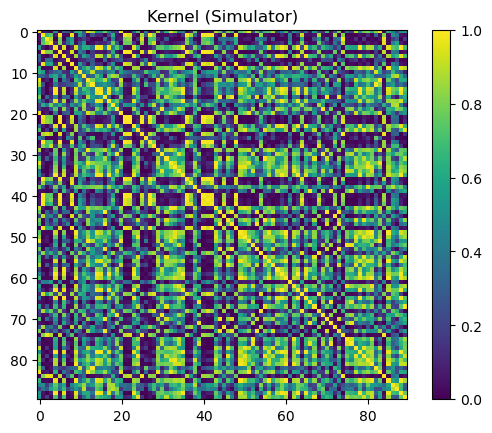

In [18]:
im = plt.imshow(kernel_simul)
plt.colorbar(im)
plt.title("Kernel (Simulator)")
plt.show()

## Classification using One vs Rest Strategy
Next I use SVC method from sklearn to apply SVM using our quantum kernel using "One vs Rest" strategy.  
For a multi-class classifier, using Kernel method, SVC applies the classification n_class number of times. For each turn,  
1. It divide the data into one vs rest of the classes (label 0 for one class, label 1 for all other classes)
2. Finds probability of data belonging to our chosen class (label 0).

After running this procedure for all classes, probabilities of data belonging to each class is obtained. Finally, the class with maximum probability is chosen as prediction.

In [19]:
from sklearn.svm import SVC

## Classifying used SVM with one vs rest strategy
svc_sklrn = SVC(kernel= kernel,decision_function_shape='ovr',probability = True)
svc_sklrn = svc_sklrn.fit(X_train, y_train)

### Probabilities of belonging to each class
Since I used one vs rest strategy, I can obtain the probabilities of data belonging to each class. The below diagram shows those probabilities over test dataset

In [25]:
prob_sklrn = svc_sklrn.predict_proba(X_test)

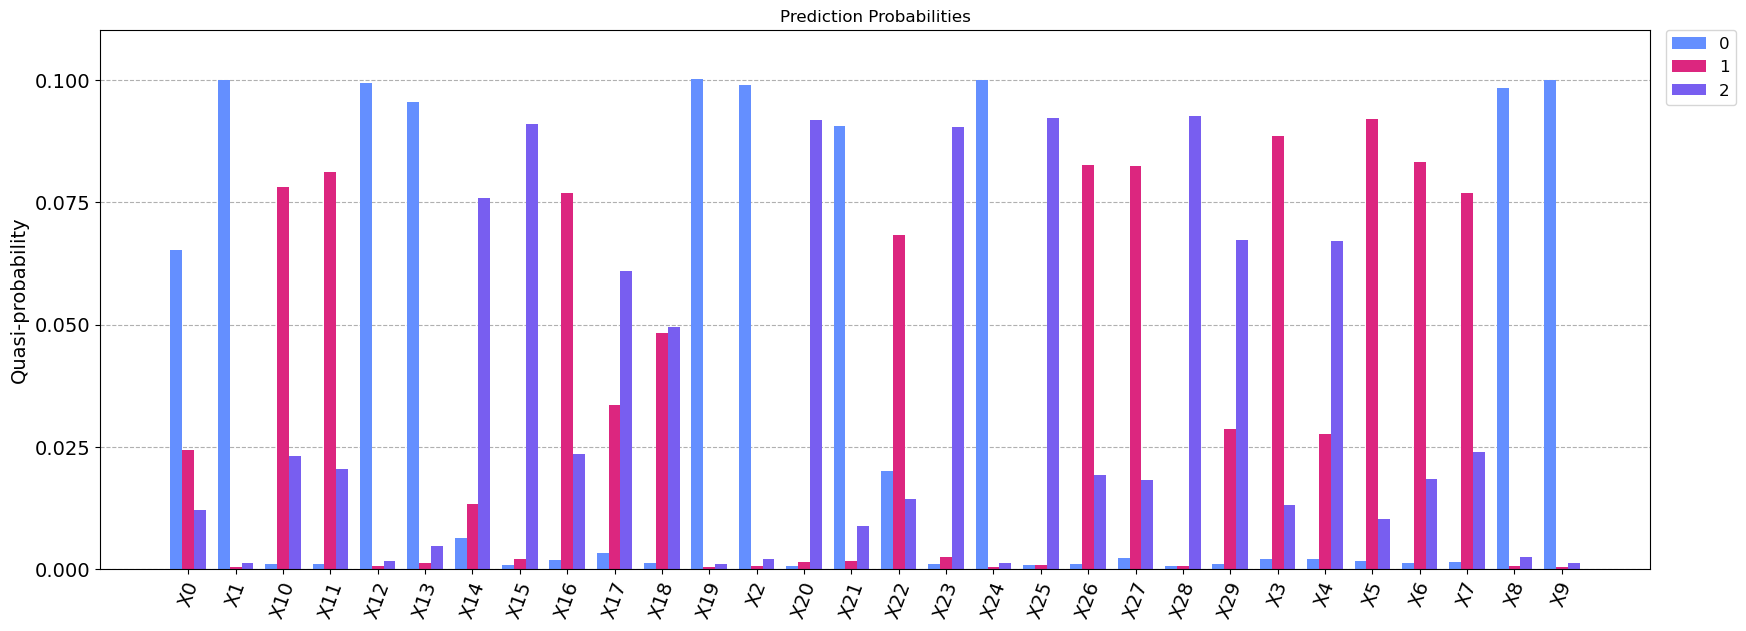

In [50]:
from qiskit.visualization import plot_histogram

plot_histogram([dict([ ("X" + str(i), prob_sklrn[i,0]) for i in range(len(prob_sklrn))]),dict([("X" + str(i), prob_sklrn[i,1]) for i in range(len(prob_sklrn))  ]), dict([ ("X" + str(i), prob_sklrn[i,2]) for i in range(len(prob_sklrn))])],
               sort = "asc",figsize= (20,7), legend= ['0', '1','2'],bar_labels=False, title= "Prediction Probabilities")


### Accuracy
We find an accuracy of 93.3333% using our QSVM

In [51]:
## Gives prediction on test data
prediction = svc_sklrn.predict(X_test)

## Measures accuracy of prediction by QSVM
prediction_sklrn = [ prediction[i]==y_test[i] for i in range(len(y_test))]
acc_sklrn = prediction_sklrn.count(True) / len(y_test) * 100
print(f"Prediction accuracy is: {acc_sklrn}%.") 

Prediction accuracy is: 93.33333333333333%.


### Incorrect Predictions
Two incorrect predictions occur in cases when probability difference between most likely answer and second most-likely answer is < 0.025

In [54]:
## Index of wrong predictions
print(np.where(np.array(prediction_sklrn)==False))

(array([16, 18]),)


### Confusion Matrix
The confusion matrix shows number of datapoints that have been correctly or incorrectly classified and the labels where it is incorrectly classified. The $i,j$-th element shows number of data-points whose predicted label is **i** and correct label is **j**. In short, row header (on the left) show predicted labels, column header(on the top) show actual labels

In [66]:
from tabulate import tabulate
from sklearn.metrics import confusion_matrix as cm

confuse = list(cm(y_test,prediction))

header = ['', 'Setosa', 'Versicolour', 'Virginica']
confuse.insert(0,header)
for i in range(1,4):
    confuse[i] = list(confuse[i])
    confuse[i].insert(0,header[i])

print(tabulate(confuse, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════╤═══════════════╤═════════════╕
│             │   Setosa │   Versicolour │   Virginica │
╞═════════════╪══════════╪═══════════════╪═════════════╡
│ Setosa      │       10 │             0 │           0 │
├─────────────┼──────────┼───────────────┼─────────────┤
│ Versicolour │        0 │             9 │           0 │
├─────────────┼──────────┼───────────────┼─────────────┤
│ Virginica   │        0 │             2 │           9 │
╘═════════════╧══════════╧═══════════════╧═════════════╛


## Final Discussion

Accuracy of 93% was achieved using this quantum kernel. 2 false predictions occured on the test data-set where difference between most-likely and second most-likely class was less than 0.025. The confusion matrix above shows both those errors occured when actual class was "Versicolour" but prediction class was "Virginica". 
Possible future directions:
1. I avoided using actual quantum hardware since I was facing incredibly long wait times. However, the code can be changed to run on actual device by changing the **simulator** argument in Kernel() function to False. There might be further necessity of symmetrizing the Kernel matrix by SPAM Twirling during circuit executions to reduce systematic errors.
2. Since we only have 3 labels, I ignored the state 11. We could make the procedure more effiecient by using a smaller subspace i.e, only the symmetric states spanned by, $|00\rangle, |11\rangle, \frac{|01\rangle + |10\rangle}{\sqrt{2}}$.One way of achieving this is by applying all the gates symmetrically on both qubits and mapping those states to appropriate labels. However, I only managed to get accuracy upto 76% by that method, using both 4 and 8 learning parameters, and hence didnt include it here.